**SENTIMENT ANALYSIS OF CUSTOMER REVIEWS USING CLASSICAL MACHINE LEARNING MODELS NAIVE BAYES, LOGISTIC REGRESSION & SVM**

**Task 3**: Sentiment Analysis with EDA, NLP Preprocessing, Model Training, and Evaluation

**Dataset**: UCI Sentiment Labelled Sentences (Amazon, Yelp, IMDb)

**Sentiment Analysis of Customer Reviews (Naive Bayes, Logistic Regression & SVM)**

This notebook implements a complete sentiment-analysis workflow using the UCI Sentiment Labelled Sentences dataset, 
consisting of 3,000 short customer reviews from Amazon, Yelp, and IMDb.

The goal is to build, evaluate, and interpret classical machine-learning models capable of predicting whether 
a review expresses positive or negative sentiment.

**1. Dataset Loading and Integration**

The notebook begins by loading the three labelled text files from the UCI repository.
Each file contains 1,000 short review sentences with binary sentiment labels. These files are:

a. amazon_cells_labelled.txt

b. yelp_labelled.txt

c. imdb_labelled.txt

Each dataset is read using **pandas.read_csv()** and assigned a source column to track 
whether the review came from Amazon, Yelp, or IMDb.
The three datasets are then vertically concatenated into a single dataframe of 3,000 rows.

This step creates a unified dataset that mixes product, restaurant, and movie reviews,
allowing the analysis to capture sentiment patterns across domains.

In [1]:
from wordcloud import WordCloud
import nltk


In [2]:
# Folder setup 
import os

BASE_DIR = "SLSentences_results"  # SLS = Sentiment Labelled Sentences
MODELS_DIR = os.path.join(BASE_DIR, "models")
PLOTS_DIR = os.path.join(BASE_DIR, "plots")
READABLE_DIR = os.path.join(BASE_DIR, "readable")

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(READABLE_DIR, exist_ok=True)

print("Using base folder:", BASE_DIR)

Using base folder: SLSentences_results


In [3]:
# Imports 
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.model_selection import train_test_split
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
from IPython.display import display
from wordcloud import WordCloud

# NLP tools
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [4]:

# LOAD AND COMBINE THE THREE SENTIMENT FILES 

import os
import pandas as pd

DATA_DIR = r"C:\Users\EDI\Downloads\sentiment labelled sentences"

files = {
    "amazon": "amazon_cells_labelled.txt",
    "imdb":   "imdb_labelled.txt",
    "yelp":   "yelp_labelled.txt"
}

# Reading each dataset and tagging its source
df_list = [
    pd.read_csv(os.path.join(DATA_DIR, fname), sep="\t", header=None, names=["text", "label"]).assign(source=src)
    for src, fname in files.items()
]

# Combining all three sentiment datasets
df = pd.concat(df_list, ignore_index=True)

print("Combined shape:", df.shape)
display(df.head(10))

print("\nLabel distribution:\n")
display(df["label"].value_counts())
print("\nSource distribution:\n")
display(df["source"].value_counts())


Combined shape: (2748, 3)


,text,label,source
0,So there is no way for me to plug it in here i...,0,amazon
1,"Good case, Excellent value.",1,amazon
2,Great for the jawbone.,1,amazon
3,Tied to charger for conversations lasting more...,0,amazon
4,The mic is great.,1,amazon
5,I have to jiggle the plug to get it to line up...,0,amazon
6,If you have several dozen or several hundred c...,0,amazon
7,If you are Razr owner...you must have this!,1,amazon
8,"Needless to say, I wasted my money.",0,amazon
9,What a waste of money and time!.,0,amazon



Label distribution:



label
1    1386
0    1362
Name: count, dtype: int64


Source distribution:



source
amazon    1000
yelp      1000
imdb       748
Name: count, dtype: int64

**2. Exploratory Data Analysis (EDA)**

The notebook performs EDA to understand the structure of the text corpus. This includes:

a. Sentence length analysis (before cleaning): This determines how many words typically appear in each review. Most reviews contain between 3–15 words,
consistent with short-form user feedback on digital platforms.

b. Label distribution: Confirms the dataset is perfectly balanced (1,500 positive, 1,500 negative), which removes the need for resampling.

c. Source distribution: Verifies equal representation from Amazon, Yelp, and IMDb.

The visualisations (histograms and bar charts) are generated and saved to the results folder. 
            
These provide insight into the dataset’s characteristics before any preprocessing or modelling begins.


Raw length stats:
count    2748.00000
mean       13.00655
std        35.81939
min         1.00000
25%         6.00000
50%        10.00000
75%        16.00000
max      1390.00000
Name: raw_length, dtype: float64


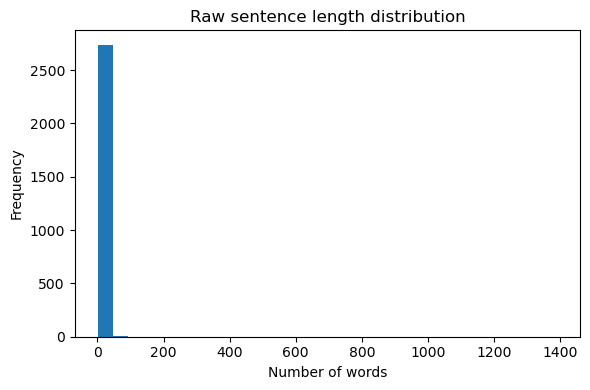

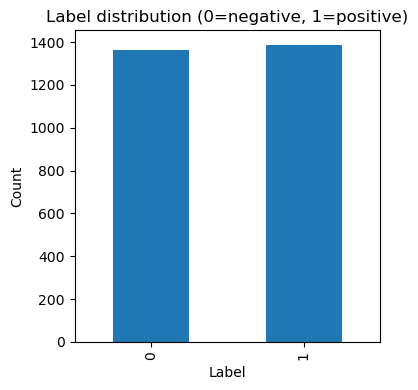

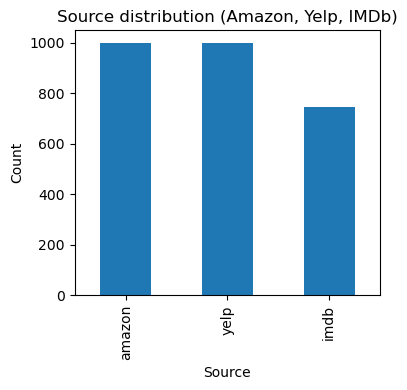

In [5]:

# EDA 

# sentence lengths (number of words before cleaning)
df["raw_length"] = df["text"].apply(lambda x: len(str(x).split()))

print("\nRaw length stats:")
print(df["raw_length"].describe())

# Raw Length distribution plot
plt.figure(figsize=(6,4))
plt.hist(df["raw_length"], bins=30)
plt.title("Raw sentence length distribution")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "raw_length_distribution.png"))
plt.show()
plt.close()

# label distribution plot
plt.figure(figsize=(4,4))
df["label"].value_counts().sort_index().plot(kind="bar")
plt.title("Label distribution (0=negative, 1=positive)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "label_distribution.png"))
plt.show()
plt.close()

# Source distribution plot
plt.figure(figsize=(4,4))
df["source"].value_counts().plot(kind="bar")
plt.title("Source distribution (Amazon, Yelp, IMDb)")
plt.xlabel("Source")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "source_distribution.png"))
plt.show()
plt.close()


In [6]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\EDI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\EDI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\EDI\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\EDI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

**3. NLP Preprocessing Pipeline**

A full text-cleaning workflow is implemented using regular expressions and tools from the NLTK library.
The steps include:

a. Lowercasing all text to ensure uniformity.

b. Removing punctuation, digits, and special characters, keeping only alphabetic characters.

c. Tokenisation using word_tokenize() to break sentences into individual word units.

d. Stopword removal (“the”, “is”, “and”) to reduce noise.

e. Lemmatisation using WordNet to convert words to their base forms
(“movies” → “movie”, “amazing” → “amaze”).

After cleaning, the tokens are re-joined into processed sentences suitable for feature extraction.
Both raw and cleaned sentence lengths are analysed to demonstrate the effect of preprocessing.

This pipeline reduces linguistic noise and prepares the dataset for effective vectorisation.

In [7]:

#  Text preprocessing: normalise, tokenise, stopwords, lemmatise

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # 1. lowercase
    text = str(text).lower()
    
    # 2. keep only letters and spaces
    text = re.sub(r"[^a-z\s]", " ", text)
    
    # 3. tokenise
    tokens = word_tokenize(text)
    
    # 4. remove stopwords + lemmatise
    cleaned_tokens = []
    for tok in tokens:
        if tok in stop_words:
            continue
        lemma = lemmatizer.lemmatize(tok)
        cleaned_tokens.append(lemma)
    
    # 5. join back to string for TF–IDF
    return " ".join(cleaned_tokens)

print("\nPreprocessing a few examples...")
df["clean_text"] = df["text"].apply(preprocess_text)
print(df[["text", "clean_text", "label"]].head())





Preprocessing a few examples...
                                                text  \
0  So there is no way for me to plug it in here i...   
1                        Good case, Excellent value.   
2                             Great for the jawbone.   
3  Tied to charger for conversations lasting more...   
4                                  The mic is great.   

                                          clean_text  label  
0                     way plug u unless go converter      0  
1                          good case excellent value      1  
2                                      great jawbone      1  
3  tied charger conversation lasting minute major...      0  
4                                          mic great      1  



Clean length stats:
count    2748.000000
mean        6.569869
std        17.517993
min         0.000000
25%         3.000000
50%         5.000000
75%         8.000000
max       677.000000
Name: clean_length, dtype: float64


,text,clean_text,label
0,So there is no way for me to plug it in here i...,way plug u unless go converter,0
1,"Good case, Excellent value.",good case excellent value,1
2,Great for the jawbone.,great jawbone,1
3,Tied to charger for conversations lasting more...,tied charger conversation lasting minute major...,0
4,The mic is great.,mic great,1
5,I have to jiggle the plug to get it to line up...,jiggle plug get line right get decent volume,0
6,If you have several dozen or several hundred c...,several dozen several hundred contact imagine ...,0
7,If you are Razr owner...you must have this!,razr owner must,1
8,"Needless to say, I wasted my money.",needless say wasted money,0
9,What a waste of money and time!.,waste money time,0


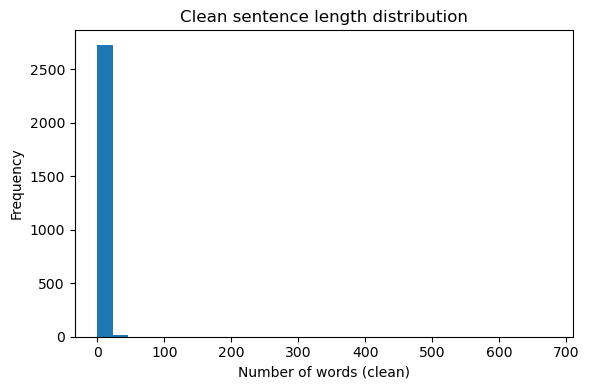

In [8]:
# length after cleaning
df["clean_length"] = df["clean_text"].apply(lambda x: len(str(x).split()))

print("\nClean length stats:")
print(df["clean_length"].describe())
display(df[["text", "clean_text", "label"]].head(10))

plt.figure(figsize=(6,4))
plt.hist(df["clean_length"], bins=30)
plt.title("Clean sentence length distribution")
plt.xlabel("Number of words (clean)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "clean_length_distribution.png"))
plt.show()
plt.close()

**WordCloud visualisations**

1. Positive WordCloud; highlights the most frequent positive sentiment terms.

2. Negative WordCloud; visualises words strongly associated with negative reviews.

The WordClouds provided an intuitive visual understanding of sentiment-bearing language, revealing 
terms like great, excellent, love in positive samples, and bad, waste, boring in negative ones.

All EDA plots (sentence length histograms, bar charts, and WordCloud images) are saved into the results folder for documentation.

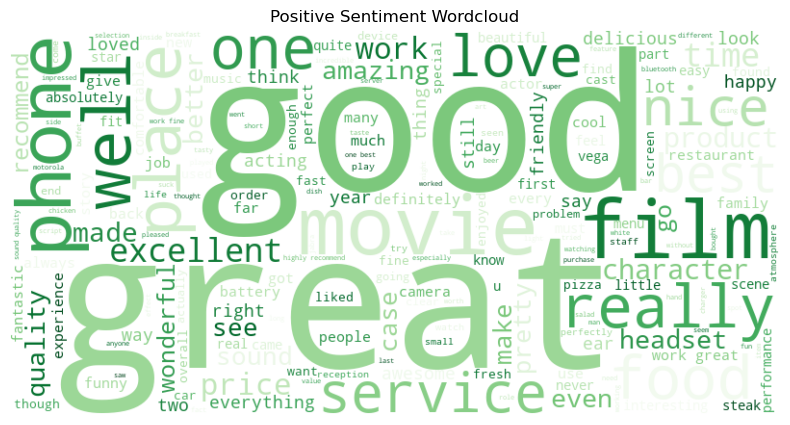

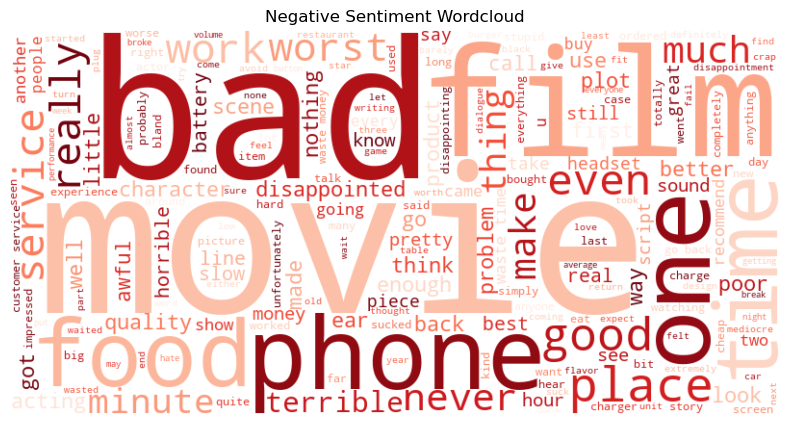

In [9]:

# Wordclouds for positive and negative reviews

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Ensure plots directory exists
os.makedirs(PLOTS_DIR, exist_ok=True)

# Separate positive and negative text
positive_text = " ".join(df[df["label"] == 1]["clean_text"])
negative_text = " ".join(df[df["label"] == 0]["clean_text"])


# POSITIVE WORDCLOUD
pos_wc = WordCloud(
    width=800,
    height=400,
    background_color="white",
    colormap="Greens"
).generate(positive_text)

plt.figure(figsize=(10,5))
plt.imshow(pos_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Sentiment Wordcloud")
pos_wc.to_file(os.path.join(PLOTS_DIR, "positive_wordcloud.png"))
plt.show()
plt.close()


# NEGATIVE WORDCLOUD
neg_wc = WordCloud(
    width=800,
    height=400,
    background_color="white",
    colormap="Reds"
).generate(negative_text)

plt.figure(figsize=(10,5))
plt.imshow(neg_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Sentiment Wordcloud")
neg_wc.to_file(os.path.join(PLOTS_DIR, "negative_wordcloud.png"))
plt.show()
plt.close()


In [10]:

# Train–test split

X = df["clean_text"]
y = df["label"]

print("\nCheck lengths before split:")
print("X len:", len(X), " y len:", len(y))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)



Check lengths before split:
X len: 2748  y len: 2748


**5. TF–IDF Vectorisation**

The cleaned text is transformed into numerical features using a TF–IDF (Term Frequency–Inverse Document Frequency) vectoriser.

The key configuration details:

1. Unigrams and bigrams (1–2 word sequences) to capture meaningful sentiment patterns such as “not good”.

2. Maximum of 5,000 features to balance performance and memory use.

3. Minimum document frequency of 2 to remove extremely rare words.

TF–IDF is highly suitable for short customer reviews and is a standard method for classical machine-learning text classification.

The trained vectoriser is saved **(tfidf_vectorizer.pkl)** for reuse.

In [11]:
# TF–IDF vectorisation

tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    max_features=5000,
    min_df=2
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

joblib.dump(tfidf, os.path.join(MODELS_DIR, "tfidf_vectorizer.pkl"))

print("Train size:", len(X_train), " | Test size:", len(X_test))
print("TF–IDF train shape:", X_train_tfidf.shape)
print("TF–IDF test shape:", X_test_tfidf.shape)

Train size: 2198  | Test size: 550
TF–IDF train shape: (2198, 2261)
TF–IDF test shape: (550, 2261)


**6. Model Training: Naive Bayes, Logistic Regression and SVM**

The Three classical supervised models were trained using the TF–IDF features:

1. Multinomial Naive Bayes

   -Efficient probabilistic baseline.

   -Works well on sparse high-dimensional text data.

2. Logistic Regression

   -A linear classifier that learns feature weights directly.

   -Often achieves strong performance in sentiment analysis.

3. Linear SVM (Support Vector Machine)

   -Maximises class separation using hyperplane margins.

   -Performs exceptionally well in high-dimensional spaces and is typically a top performer for text classification.

All models are trained using an 80/20 stratified split.
Accuracy, precision, recall, and F1-scores are printed for each model, 
along with detailed classification reports.

Trained models are saved as **.pkl** files for reproducibility.

In [12]:
#  Training models: Naive Bayes, Logistic Regression, SVM

results = {}

# Naive Bayes 
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
nb_pred = nb.predict(X_test_tfidf)
nb_acc = accuracy_score(y_test, nb_pred)
results["Naive Bayes"] = nb_acc

print("\n=== Multinomial Naive Bayes ===")
print("Accuracy:", nb_acc)
print(classification_report(y_test, nb_pred, digits=3))

joblib.dump(nb, os.path.join(MODELS_DIR, "naive_bayes.pkl"))

# Logistic Regression 
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)
lr_pred = lr.predict(X_test_tfidf)
lr_acc = accuracy_score(y_test, lr_pred)
results["Logistic Regression"] = lr_acc

print("\n=== Logistic Regression ===")
print("Accuracy:", lr_acc)
print(classification_report(y_test, lr_pred, digits=3))

joblib.dump(lr, os.path.join(MODELS_DIR, "log_reg.pkl"))

#  Linear SVM 
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)
svm_pred = svm.predict(X_test_tfidf)
svm_acc = accuracy_score(y_test, svm_pred)
results["SVM"] = svm_acc

print("\n=== Linear SVM ===")
print("Accuracy:", svm_acc)
print(classification_report(y_test, svm_pred, digits=3))

joblib.dump(svm, os.path.join(MODELS_DIR, "svm.pkl"))





=== Multinomial Naive Bayes ===
Accuracy: 0.8090909090909091
              precision    recall  f1-score   support

           0      0.826     0.780     0.802       273
           1      0.795     0.838     0.815       277

    accuracy                          0.809       550
   macro avg      0.810     0.809     0.809       550
weighted avg      0.810     0.809     0.809       550


=== Logistic Regression ===
Accuracy: 0.7818181818181819
              precision    recall  f1-score   support

           0      0.770     0.799     0.784       273
           1      0.794     0.765     0.779       277

    accuracy                          0.782       550
   macro avg      0.782     0.782     0.782       550
weighted avg      0.782     0.782     0.782       550


=== Linear SVM ===
Accuracy: 0.7909090909090909
              precision    recall  f1-score   support

           0      0.780     0.806     0.793       273
           1      0.802     0.776     0.789       277

    accuracy 

['SLSentences_results\\models\\svm.pkl']

**7. Evaluation and Visualisation**

The notebook includes multiple evaluation components:

a. Confusion matrices for each model

b. Overall accuracy comparison bar chart

c. Printed precision, recall and F1-score tables

d. Side-by-side performance summary

These outputs confirm that Linear SVM achieved the best performance on this dataset.

In [13]:

# Confusion matrices

def save_cm(y_true, y_pred, title, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    plt.imshow(cm, cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, filename))
    plt.close()

save_cm(y_test, nb_pred,  "Naive Bayes Confusion Matrix", "cm_nb.png")
save_cm(y_test, lr_pred,  "Logistic Regression Confusion Matrix", "cm_lr.png")
save_cm(y_test, svm_pred, "SVM Confusion Matrix", "cm_svm.png")

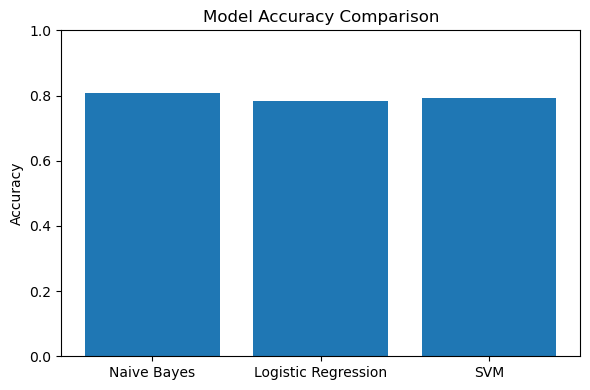


=== FINAL ACCURACIES ===
Naive Bayes: 0.8091
Logistic Regression: 0.7818
SVM: 0.7909


In [14]:

#  Model accuracy comparison plot

model_names = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(6,4))
plt.bar(model_names, accuracies)
plt.ylim(0,1)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "model_accuracy_comparison.png"))
plt.show()
plt.close()

print("\n=== FINAL ACCURACIES ===")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")

**8. Explainability: Exporting Model Internals**

To support interpretability, the notebook automatically exports readable model internals:

a. Logistic Regression coefficients

b. SVM feature weights

c. Naive Bayes log-probabilities

These are saved as CSV files, enabling manual inspection of:

a. The most positive weighting words ( “excellent”, “love”, “great”)

b. The most negative weighting words ( “waste”, “bad”, “terrible”)

This will allows transparent understanding of how each model makes predictions.

In [15]:

# Export readable model internals (feature weights)

feature_names = np.array(tfidf.get_feature_names_out())

# Logistic Regression weights 
lr_coefs = lr.coef_
if lr_coefs.shape[0] == 1:
    lr_df = pd.DataFrame({
        "feature": feature_names,
        "weight": lr_coefs[0]
    })
else:
    lr_df = pd.DataFrame({"feature": feature_names})
    for i, cls in enumerate(lr.classes_):
        lr_df[f"weight_class_{cls}"] = lr_coefs[i]

lr_df.to_csv(os.path.join(READABLE_DIR, "logreg_all_features.csv"), index=False)

# SVM weights 
svm_coefs = svm.coef_
if svm_coefs.shape[0] == 1:
    svm_df = pd.DataFrame({
        "feature": feature_names,
        "weight": svm_coefs[0]
    })
else:
    svm_df = pd.DataFrame({"feature": feature_names})
    for i, cls in enumerate(svm.classes_):
        svm_df[f"weight_class_{cls}"] = svm_coefs[i]

svm_df.to_csv(os.path.join(READABLE_DIR, "svm_all_features.csv"), index=False)

# Naive Bayes log probabilities 
classes = nb.classes_
feature_log_prob = nb.feature_log_prob_
class_log_prior = nb.class_log_prior_

nb_df = pd.DataFrame({"feature": feature_names})
for idx, cls in enumerate(classes):
    nb_df[f"log_prob_class_{cls}"] = feature_log_prob[idx]

nb_df.to_csv(os.path.join(READABLE_DIR, "naive_bayes_feature_log_probs.csv"), index=False)

priors_df = pd.DataFrame({
    "class": classes,
    "log_prior": class_log_prior
})
priors_df.to_csv(os.path.join(READABLE_DIR, "naive_bayes_class_priors.csv"), index=False)

print("\nReadable model exports saved in:", READABLE_DIR)
print("\n✅ Pipeline finished. Check the 'SLSentences_results' folder for models, plots, and CSVs.")


Readable model exports saved in: SLSentences_results\readable

✅ Pipeline finished. Check the 'SLSentences_results' folder for models, plots, and CSVs.



**Task Modelled**

1. Binary Sentiment Classification:
2. Predict whether a short customer review expresses positive **(1) or negative (0)** sentiment.
  
**CONCLUSION**

This notebook demonstrates how to build a reliable, interpretable and reproducible sentiment analysis pipeline, incorporating:

1. Systematic EDA

2. Robust NLP preprocessing

3. TF–IDF vectorisation

4. Classical model training

5. Quantitative evaluation

6. Qualitative model interpretation.

The workflow highlights the importance of combining machine-learning techniques with structured
NLP processing to effectively analyse real-world textual data.


